In [ ]:
!pip install albumentations
!pip install efficientnet_pytorch

In [1]:
#импортируем все что пригодится
import numpy as np 
import pandas as pd 
import shutil
import os
import zipfile
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torch.nn.functional as F
import copy
import tqdm
import time
import random
from PIL import Image
from sklearn.preprocessing import LabelEncoder

import albumentations
from albumentations import pytorch as AT

#from efficientnet_pytorch import EfficientNet

%matplotlib inline

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
with zipfile.ZipFile('/content/drive/MyDrive/taskonML/train.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

with zipfile.ZipFile('/content/drive/MyDrive/taskonML/test.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [17]:
train_dir = '/content'
test_dir = '/content/test'

In [18]:
train_data = pd.read_csv('/content/drive/MyDrive/taskonML/train_labels.csv')
kl = np.asarray(train_data['sports'].unique())

In [16]:
len(kl)

22

In [19]:
encoder = LabelEncoder()
train_data['num_labels'] = encoder.fit_transform(train_data['sports'])

In [ ]:
list (map(lambda x:x[1:], train_data['image'])) 

In [19]:
train_files = os.listdir(train_dir + '/train')
train_files = train_data
train_files

,image,sports,num_labels
0,./train/0.jpg,baseball,1
1,./train/1.jpg,formula1,8
2,./train/2.jpg,fencing,6
3,./train/3.jpg,motogp,13
4,./train/4.jpg,ice_hockey,11
...,...,...,...
11035,./train/11035.jpg,motogp,13
11036,./train/11036.jpg,motogp,13
11037,./train/11037.jpg,football,7
11038,./train/11038.jpg,football,7


In [20]:
class CustomDataset(Dataset):
    def __init__(self, file_csv, dir, transform=None, mode = 'train'):
        self.file_csv = file_csv
        self.dir = dir
        self.transform = transform
        self.mode = mode
            
    def __len__(self):
        return len(self.file_csv)
    
    #метод который позволяет нам индексировать датасет
    def __getitem__(self, idx):
        #считываем изображение
        image = cv2.imread(os.path.join(self.dir, self.file_csv['image'][idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        self.label = int(train_data['num_labels'][idx])
        
        #применяем аугментации
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        if self.mode == 'train':
            return image, float(self.label)
        else:
            return image, self.file_csv['image'][idx]

In [11]:
#зададим немного гиперпараметров
batch_size = 32
num_workers = 2
img_size = 256

In [12]:
#Набор аугментаций. 

data_transforms = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

#обычно аугментации для трейн и тест датасетов разделают. 
#На тесте обычно не нужно сильно изменять изображения
data_transforms_test = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.HorizontalFlip(),
    albumentations.RandomRotate90(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

In [23]:
trainset = CustomDataset(train_files, train_dir, transform = data_transforms)
#test_set = CustomDataset(test_files, test_dir, transform=data_transforms_test, mode = 'test')

In [24]:
train_size = int(0.7 * len(train_files))
valid_size = int(0.15 * len(train_files))
test_size = len(train_files) - train_size - valid_size
train_set, valid_set, test_set = torch.utils.data.random_split(
    trainset, (train_size, valid_size, test_size), generator=torch.Generator().manual_seed(42))

In [25]:
#Доработать!!!!!
#from sklearn import model_selection, metrics
#train, test = model_selection.train_test_split(
#    train_data, test_size=0.14, random_state=42
#    , stratify=train_files.num_labels.values
#)
#train, validate = model_selection.train_test_split(
#    train, test_size=0.15, random_state=42
#    , stratify=train.num_labels.values
#)
#train_set = CustomDataset(train, train_dir, transform = data_transforms)
#valid_set = CustomDataset(validate, train_dir, transform = data_transforms)
#test_set = CustomDataset(test, train_dir, transform = data_transforms)

In [26]:
len(train_set), len(valid_set), len(test_set)

(7727, 1656, 1657)

In [27]:
trainloader = torch.utils.data.DataLoader(train_set, pin_memory=True, 
                                        batch_size=batch_size, shuffle=True, 
                                        num_workers=num_workers)
validloader = torch.utils.data.DataLoader(valid_set, pin_memory=True, 
                                        batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(test_set, batch_size = batch_size,
                                        num_workers = num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 6., 16., 20., 15.,  7., 14., 14., 17., 16.,  6., 18.,  1., 10., 17.,
        17., 16., 13., 21., 20.,  5., 19., 17., 19., 18., 12.,  1.,  3.,  0.,
        18., 19.,  1.,  4.], dtype=torch.float64)


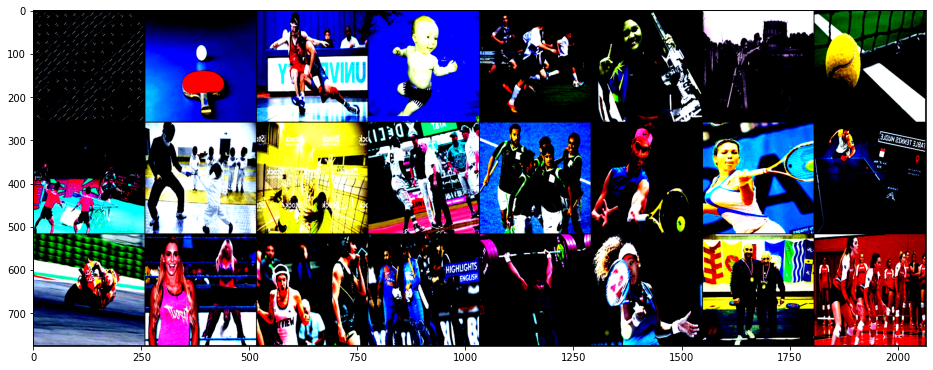

In [28]:
#Проверим работоспособность
samples, labels = next(iter(trainloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
#  чтобы вывести изображение, нужно его немного преобразовать из тензора обратно в нампай
print(labels)
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [30]:
model = torchvision.models.resnet152(pretrained=True, progress=True)
#заморозим веса, чтобы использовать полностью предобученную сетку
for param in model.parameters():
    param.requires_grad = False

#model

In [31]:
model.fc = nn.Linear(2048, 22)
#model

In [32]:
def train_model(model_conv, train_loader, valid_loader, criterion, optimizer, scheduler, n_epochs):
    model_conv.to(device)
    valid_loss_min = np.Inf
    patience = 5
    # сколько эпох ждем до отключения
    p = 0
    # иначе останавливаем обучение
    stop = False

    # количество эпох
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)

        train_loss = []

        for batch_i, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model_conv(data)
            loss = criterion(output, target.long())
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
    # запускаем валидацию
        model_conv.eval()
        correct = 0
        val_loss = []
        for batch_i, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model_conv(data)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
            loss = criterion(output, target.long())
            val_loss.append(loss.item()) 
        
        acc = correct / len(valid_set)

        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')
        print(f'Accuracy on valid set: {acc}')

        valid_loss = np.mean(val_loss)
        scheduler.step(valid_loss)
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model_conv.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
            p = 0

        # проверяем как дела на валидации
        if valid_loss > valid_loss_min:
            p += 1
            print(f'{p} epochs of increasing val loss')
            if p > patience:
                print('Stopping training')
                stop = True
                break        

        if stop:
            break
    return model_conv, train_loss, val_loss

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2,)

In [36]:
model_resnet, train_loss, val_loss = train_model(model, trainloader, validloader, criterion, 
                              optimizer, scheduler, n_epochs=30,)

Sun Apr 25 16:50:49 2021 Epoch: 1
Epoch 1, train loss: 0.9637, valid loss: 0.5225.
Accuracy on valid set: 0.8635265700483091
Validation loss decreased (inf --> 0.522528).  Saving model ...
Sun Apr 25 16:52:27 2021 Epoch: 2


KeyboardInterrupt: ignored

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [37]:
#загрузим лучшую модель и проведем на ней инференс (прогон тестовых данных)
model.state_dict(torch.load('/content/model.pt'))
print(1)

1


In [38]:
model.eval()
correct = 0

with torch.no_grad():
  for data, target in testloader:
    data = data.to(device=device)
    target = target.to(device=device)
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == target).sum().item()


acc = correct / len(test_set)
print(f'Accuracy on test set: {acc}')

Accuracy on test set: 0.852142426071213


In [ ]:
#Проверим работоспособность
samples, labels = next(iter(testloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
#  чтобы вывести изображение, нужно его немного преобразовать из тензора обратно в нампай
print(labels)
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [46]:
from pathlib import Path

model.to(device)
model.eval()
df_preds = pd.DataFrame()
for path in Path('/content/ttest').iterdir():
    img = cv2.imread(str(path))[:, ::-1]
    img = data_transforms_test(image=img)['image'].cuda()
    pred = model(img[None])
    
    df_preds = df_preds.append(
        {'image': path.absolute(), 'labels': encoder.inverse_transform(torch.argmax(pred.cpu(), dim=1))[0]},
        ignore_index=True)
    
df_preds

,image,labels
0,/content/ttest/7.jpg,cricket
1,/content/ttest/4.jpg,ice_hockey
2,/content/ttest/2.jpg,boxing
3,/content/ttest/6.jpg,volleyball
4,/content/ttest/3.jpg,motogp
5,/content/ttest/1.jpg,cricket
6,/content/ttest/5.jpg,swimming


In [ ]:
df_preds.to_csv('/content/submission.csv', index = False)

In [3]:
with zipfile.ZipFile('/content/drive/MyDrive/taskonML/ttest.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

with zipfile.ZipFile('/content/drive/MyDrive/taskonML/model.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [4]:
weight = '/content/model.pt'
path_to_dataset = '/content/ttest'

In [17]:
def infer(weight, path_to_dataset):
  from pathlib import Path
  from sklearn.preprocessing import LabelEncoder

  img_size = 256

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = torchvision.models.resnet152(pretrained=True, progress=True)
  model.fc = nn.Linear(2048, 22)

  model.load_state_dict(torch.load(weight))

  #train_data = pd.read_csv('/content/drive/MyDrive/taskonML/train_labels.csv')
  #encoder = LabelEncoder()
  #train_data['num_labels'] = encoder.fit_transform(train_data['sports'])

  labels_class = ['badminton',
                  'baseball',
                  'basketball',
                  'boxing',
                  'chess',
                  'cricket',
                  'fencing',
                  'football',
                  'formula1',
                  'gymnastics',
                  'hockey',
                  'ice_hockey',
                  'kabaddi',
                  'motogp',
                  'shooting',
                  'swimming',
                  'table_tennis',
                  'tennis',
                  'volleyball',
                  'weight_lifting',
                  'wrestling',
                  'wwe']

  data_transforms = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.Normalize(),
    AT.ToTensor()
    ]) 
  
  model.to(device)
  model.eval()
  df_preds = pd.DataFrame()
  for path in Path(path_to_dataset).iterdir():
    img = cv2.imread(str(path))[:, ::-1]
    img = data_transforms(image=img)['image'].cuda()
    pred = model(img[None])
    
    df_preds = df_preds.append(
        {'image': path.absolute(), 'labels': labels_class[torch.argmax(pred.cpu(), dim=1)]},
        ignore_index=True)
  df_preds.to_csv('/content/submission.csv', index = False)

In [18]:
infer(weight, path_to_dataset)